In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools
import cv2
import skimage.measure as measure
import scipy
import math

In [2]:
def show_gray_img(img, title='title'):
    plt.figure(figsize=(10, 10))
#     plt.subplot(pos)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    
def show_img(img, title='title', figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)

In [3]:
lung_roi = tools.get_arr_from_nii("data/output/lung-roi.nii")
SPACING_X = SPACING_Y = 0.731
SPACING_Z = 2.5
print(SPACING_X, SPACING_Y, SPACING_Z)

0.731 0.731 2.5


In [4]:
lung_roi.shape
slice = lung_roi[188]
# slice = lung_roi[120]

#  参考自论文：检测肺结节的3维自适应模板匹配 

1. 对边缘检测的结果进行联通，联通之后对每个区域进行开运算 
2. 移除面积较小的区域（小于层厚）


array([0, 1], dtype=uint8)

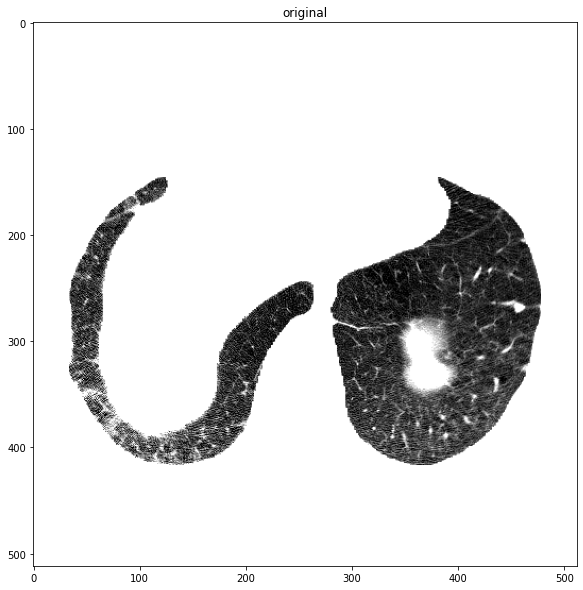

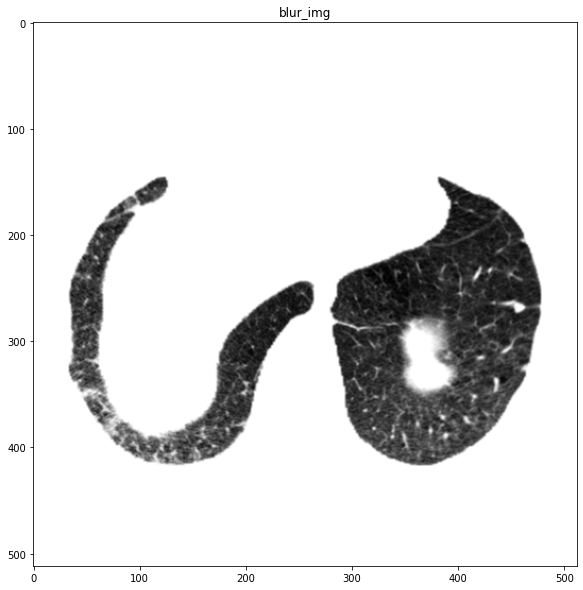

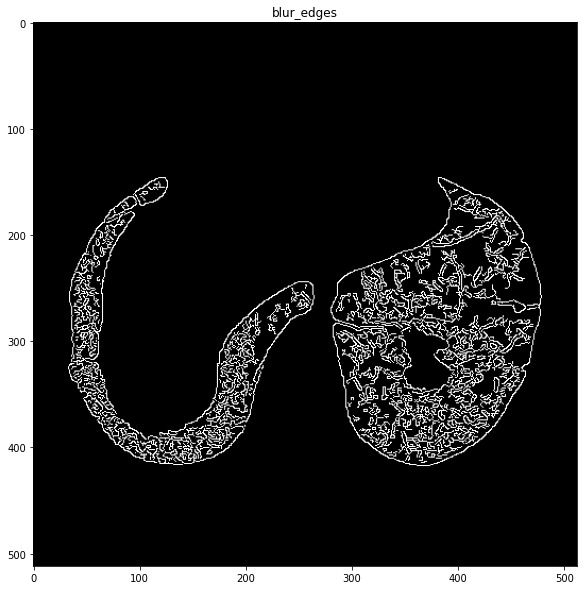

In [5]:
# 边缘检测
# 窗位-650, 窗宽1000, 滤波和边缘检测都使用np.uint8
window_start = -1150
window_end = -150 # 注意,非肺部的地方像素值为0
slice_u8 = tools.get_window_img(slice, (-1150, -150))
# 
show_gray_img(slice_u8, 'original')

canny_th1 = 50
canny_th2 = 200

# canny_th1 = 200
# canny_th2 = 500

# 不做滤波的边缘检测
# edges = cv2.Canny(slice_u8, canny_th1, canny_th2)
# show_gray_img(edges, 'edges')

# 高斯滤波之后的边缘检测
slice_u8_blur = cv2.GaussianBlur(slice_u8, (3, 3), 0)
show_gray_img(slice_u8_blur, 'blur_img')
edges_blur = cv2.Canny(slice_u8_blur, canny_th1, canny_th2)
show_gray_img(edges_blur, 'blur_edges')
edges_blur[edges_blur==255] = 1
np.unique(edges_blur)

In [6]:
# 求取数组的众数
arr = np.array([1, 2,3,3,3,4,4,4,4,45,6])
# scipy.stats.mode(arr)[0]

# 统计个数
np.sum(arr == 4)

4

In [7]:
# Make sure cells closed
# kernel = np.ones((3, 3), np.uint8)
# show_gray_img(edges_blur)
# edges_blur = cv2.morphologyEx(edges_blur, cv2.MORPH_CLOSE, kernel)
# show_gray_img(edges_blur)
# print(np.unique(edges_blur))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1]


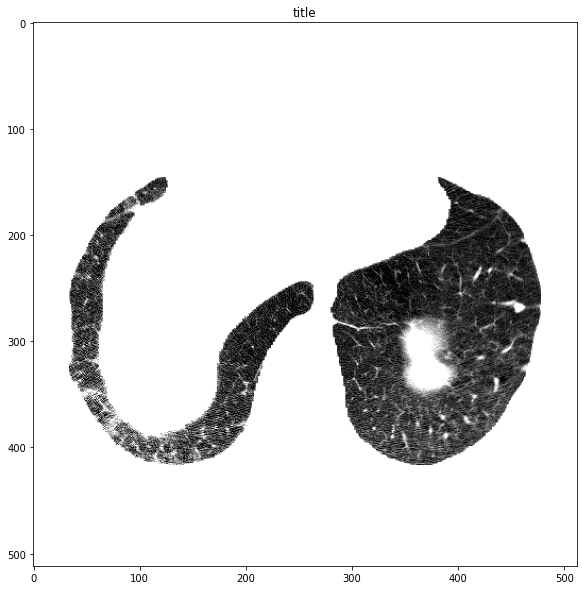

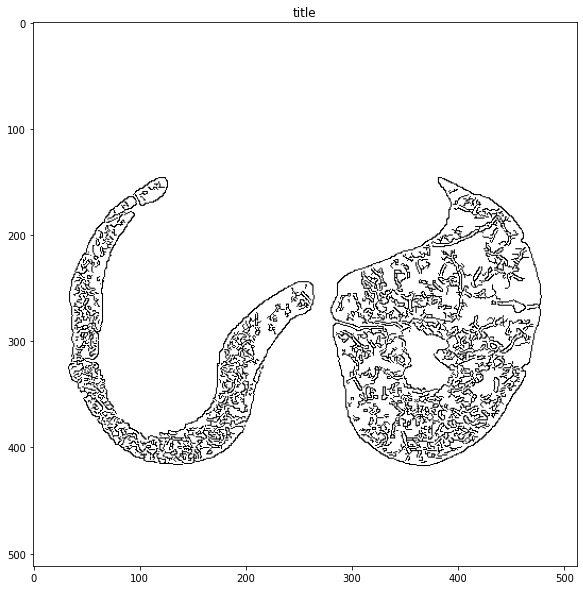

In [8]:
# edges_blur[edges_blur==255] = 1
print(edges_blur)
print(np.unique(edges_blur))
edges_blur[edges_blur==0] = 2
edges_blur[edges_blur==1] = 0
edges_blur[edges_blur==2] = 1
# seperate = edges_blur * slice_u8
show_gray_img(slice_u8)
show_gray_img(edges_blur)
# show_gray_img(seperate)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221]


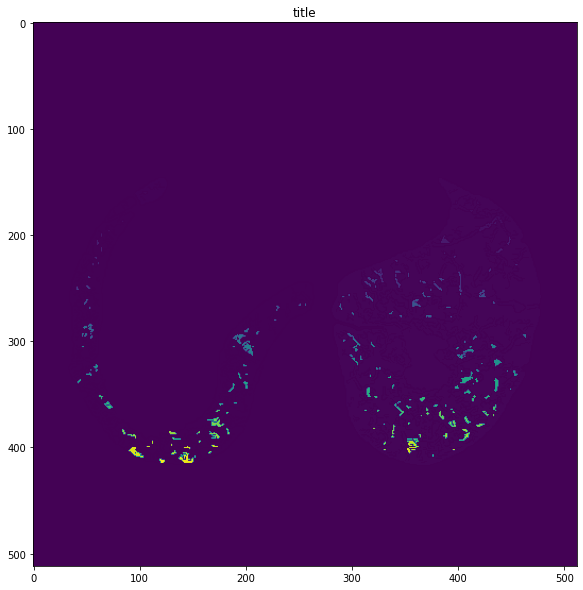

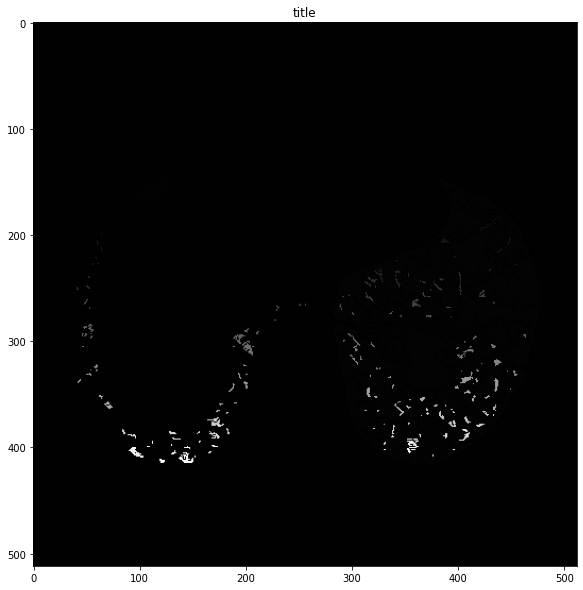

In [9]:
# 联通域连接

def connect_seperate(seperate):
    # 取得原点像素的label_value，其它位置设置为1，很容易知道原点是属于背景，其它位置属于前景
    seperate_connected = measure.label(seperate, connectivity=1)
    init_label_value = seperate_connected[0, 0]
    unused_value = seperate_connected.max() + 1
    print(f'init_label_value: {init_label_value}, unused_value: {unused_value}')
    seperate_connected[seperate_connected!=init_label_value] = unused_value
    seperate_connected[seperate_connected==init_label_value] = 1
    seperate_connected[seperate_connected==unused_value] = 0
    return seperate_connected

seperate_connected = measure.label(edges_blur, connectivity=1)
# seperate_connected = connect_seperate(edges_blur)

show_img(seperate_connected)
show_gray_img(seperate_connected)
print(np.unique(seperate_connected))

In [10]:
# 计算每个连通域的面积，一个像素点面积是 0.731*0.731，如果边长为层厚则面积为2.5*2.5，所以需要像素点为
# 1 移除小面积（小于层厚区域？？？）的区域；/ 使用层厚大小的核开运算
# 2. 移除超大面结的区域，大于直径30mm圆的区域。
# 3. 移除长轴大于30mm的区域
pixel_num_min = SPACING_Z * SPACING_Z / SPACING_X / SPACING_Y
pixel_num_max = math.pi * 15 * 15 / (SPACING_X * SPACING_X)
print(pixel_num_min, pixel_num_max)

11.696212859845684 1322.810510231292


some area ignored, small area: 177, large area: 3 
43


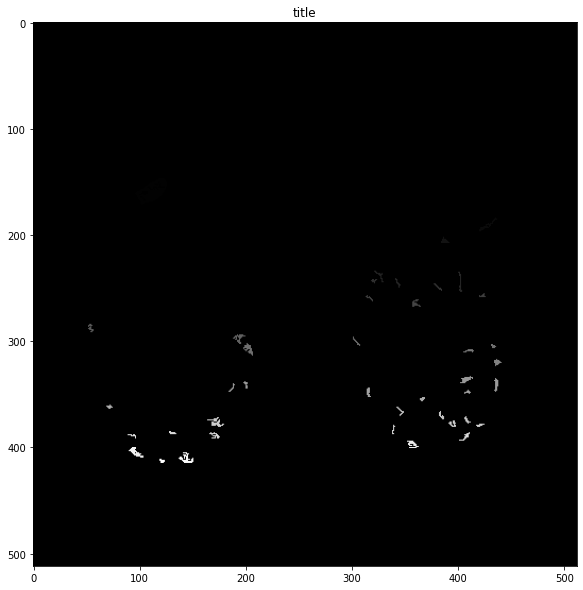

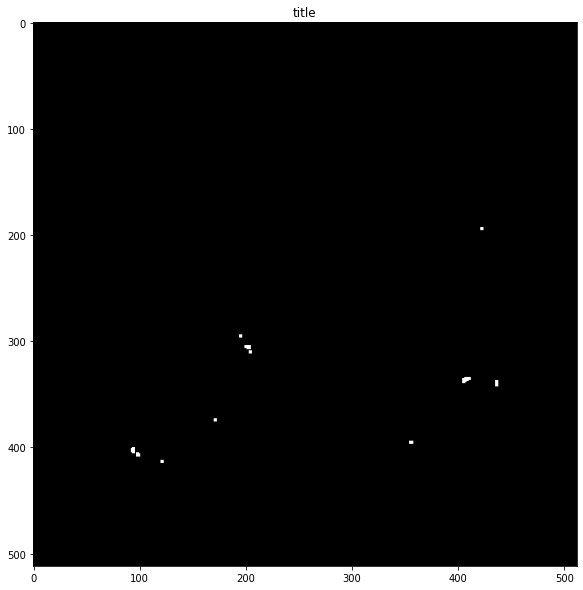

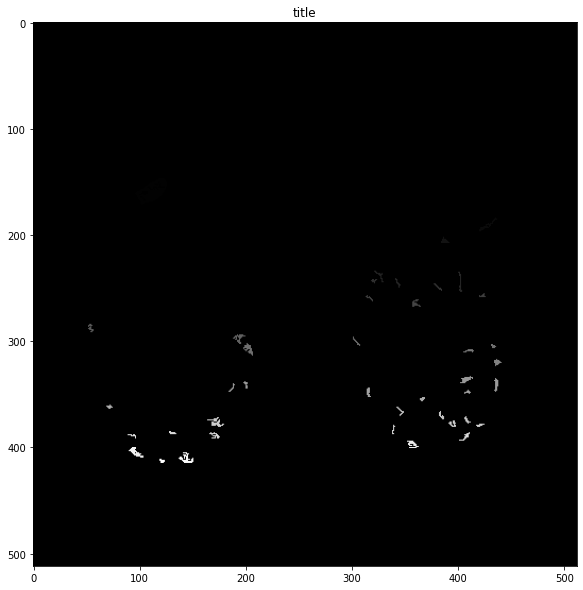

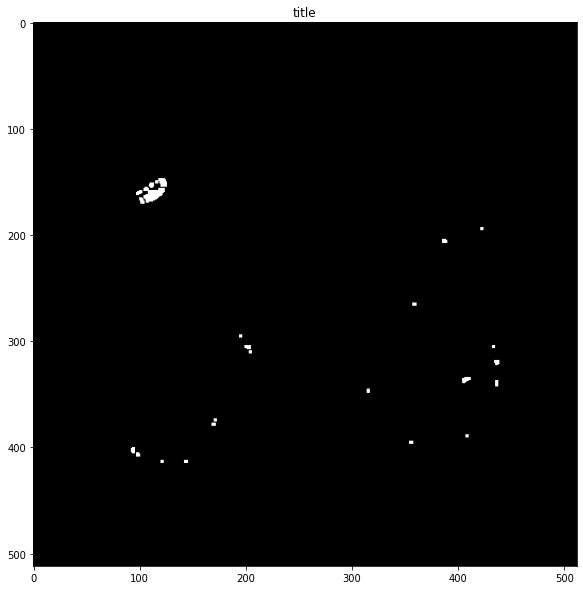

In [11]:
# 对检测区域进行初步筛选（简易）
# 把0空出来留给背景（非ROI）
seperate_connected[seperate_connected==0] = seperate_connected.max() + 1
large_area_count = 0
small_area_count = 0
for v in np.unique(seperate_connected):
    pixel_num = np.sum(seperate_connected == v)
    if pixel_num < pixel_num_min:
        seperate_connected[seperate_connected == v] = 0
        small_area_count += 1
    elif pixel_num > pixel_num_max:
        seperate_connected[seperate_connected == v] = 0
        large_area_count += 1
print(f'some area ignored, small area: {small_area_count}, large area: {large_area_count} ')
# show_img(seperate_connected)
show_gray_img(seperate_connected)

# 显然，背景区域会被设为unused_value，且unused_value不可能为1
# 准备进行开运算，消除小于层厚的区域（同时去除了毛刺）
kernel = np.ones((3, 3), np.uint8)
seperate_mask = seperate_connected.astype(np.uint8)
seperate_mask[seperate_mask!=0] = 1 
seperate_mask = cv2.morphologyEx(seperate_mask, cv2.MORPH_OPEN, kernel)
show_gray_img(np.bitwise_and(seperate_connected, seperate_mask))
show_gray_img(seperate_connected)
show_gray_img(seperate_mask)
print(len(np.unique(seperate_connected)))

numer of contours: 23


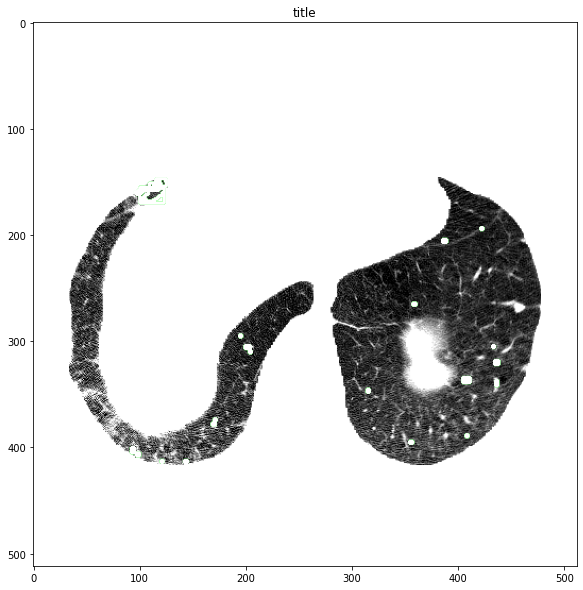

In [13]:
# 移除直径大于30mm的区域
# 至此，得到的可能有肺结节，血管，钙化点，淋巴管
# https://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/
spacing = 0.731 # Z方向
MAX_SIZE = 30 # todo update to 30mm
# 这一步检测到的轮廓变少了，比连通区域数目少，无妨，反正这步是为了丢弃大区域，大区域大轮廓按道理是不会漏检的
contours, hierarcy = cv2.findContours(seperate_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(f"numer of contours: {len(contours)}") 
# print(len(contoours), contoours, hierarcy)


img = cv2.cvtColor(slice_u8, cv2.COLOR_GRAY2BGRA)
my_contours = list()
# 对每个对象使用矩形包裹
for cont in contours:
    rect = cv2.minAreaRect(cont)
    # print(rect)
    # (坐标，尺寸，角度）
    if max(rect[1]) > MAX_SIZE / spacing:
        o_x, o_y = rect[0]
        # remove this object by index, firstly, get the region id
        roi_id = seperate_connected[int(o_x), int(o_y)]
        print(f'A large object detected: {max(rect[1])} pixels, at {o_x}, {o_y}, region_id: {roi_id}')
        seperate_connected[seperate_connected==roi_id] = 0
        break
    
    rect = cv2.boxPoints(rect)
    my_contours.append(cont)
    my_contours.append(rect.astype(np.int))
#     my_contours = [rect.astype(np.int)]
img = cv2.drawContours(img, my_contours, -1, (0, 255, 0), 2)
show_img(img)

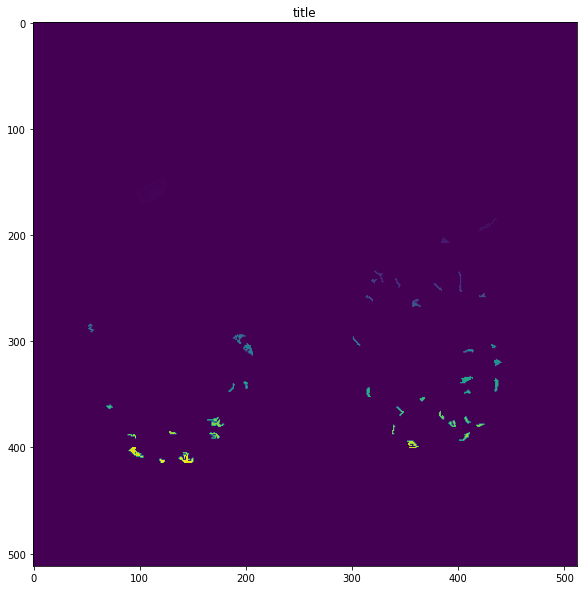

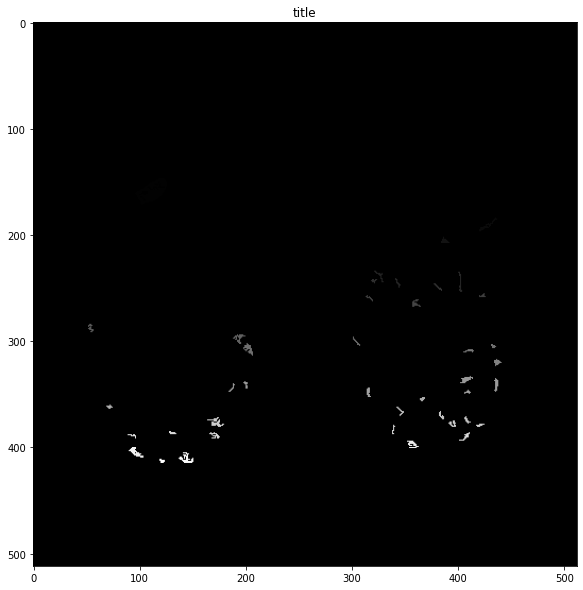

In [15]:
show_img(seperate_connected)
show_gray_img(seperate_connected)